# 1. 폰트 설정 및 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import math
from influxdb_client import InfluxDBClient


# 1. 폰트 경로 명시적 지정
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
font_name = fontprop.get_name()

# 2. matplotlib 전역 설정
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

# 3. seaborn과 충돌 방지 (스타일 먼저 설정하고 폰트를 다시 지정)
sns.set_style("whitegrid")
plt.rcParams['font.family'] = font_name




# 2. Influx DB 

In [2]:
# InfluxDB 연결 설정
INFLUX_URL   = "https://influx.aiot2.live"
INFLUX_TOKEN = "VNFU9_2LZAkeF299VqVqTI6UL7kKqYfvyy4qeesEXnqlEIIl2W6fNMznsBZI15BKopp2wMB5kfk7xexzJhHgJw=="
INFLUX_ORG   = "aiot2-team2-coffee"
INFLUX_BUCKET= "coffee-mqtt"

# InfluxDB 클라이언트 생성
client = InfluxDBClient(
    url=INFLUX_URL,
    token=INFLUX_TOKEN,
    org=INFLUX_ORG
)
read_api = client.query_api()

# 센서 타입 정의
sensor_types = [
    "co2", "distance", "humidity", "illumination", "infrared", "pressure",
    "temperature", "infrared_and_visible", "occupancy", "battery_level",
    "activity", "battery"
]

# 센서 타입 필터 생성
sensor_filter = ' or '.join([f'r["type"] == "{t}"' for t in sensor_types])

# Flux 쿼리 작성
flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -1d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => {sensor_filter})
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
'''

# 데이터 쿼리 및 전처리
df = read_api.query_data_frame(flux)

if isinstance(df, list):
    df = pd.concat(df)

df = df.reset_index().rename(columns={"_time": "time"})
df = df.set_index("time")

# 데이터 확인
print("데이터 샘플:")
display(df.head())
print(f"데이터 크기: {df.shape}")


/opt/homebrew/anaconda3/lib/python3.12/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
from(bucket: "coffee-mqtt")
  |> range(start: -1d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["type"] == "co2" or r["type"] == "distance" or r["type"] == "humidity" or r["type"] == "illumination" or r["type"] == "infrared" or r["type"] == "pressure" or r["type"] == "temperature" or r["type"] == "infrared_and_visible" or r["type"] == "occupancy" or r["type"] == "battery_level" or r["type"] == "activity" or r["type"] == "battery")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnin

데이터 샘플:


,index,result,table,_start,_stop,_value,_field,_measurement,location,type
time,,,,,,,,,,
2025-04-22 12:20:00+00:00,0,mean,0,2025-04-22 05:54:00.177925+00:00,2025-04-23 05:54:00.177925+00:00,32.0,value,sensor,2,battery
2025-04-22 12:25:00+00:00,1,mean,0,2025-04-22 05:54:00.177925+00:00,2025-04-23 05:54:00.177925+00:00,32.0,value,sensor,2,battery
2025-04-22 12:30:00+00:00,2,mean,0,2025-04-22 05:54:00.177925+00:00,2025-04-23 05:54:00.177925+00:00,32.0,value,sensor,2,battery
2025-04-22 12:35:00+00:00,3,mean,0,2025-04-22 05:54:00.177925+00:00,2025-04-23 05:54:00.177925+00:00,32.0,value,sensor,2,battery
2025-04-22 12:40:00+00:00,4,mean,0,2025-04-22 05:54:00.177925+00:00,2025-04-23 05:54:00.177925+00:00,32.0,value,sensor,2,battery


데이터 크기: (6808, 10)


In [3]:
# 센서 타입 한글 매핑
sensor_type_mapping = {
    'temperature': '실내 온도(°C)',
    'humidity': '상대습도(%)',
    'co2': '이산화탄소 농도(ppm)',
    'tvoc': '총휘발성유기화합물(ppb)',
    'pressure': '대기압(hPa)',
    'occupancy': '재실 여부',
    'activity': '활동 수준',
    'distance': '거리(cm)',
    'illumination': '조도(lux)',
    'infrared': '적외선',
    'infrared_and_visible': '적외선 및 가시광선',
    'battery': '배터리 상태',
    'battery_level': '배터리 잔량(%)'
}

# 불쾌지수 계산 함수
def calculate_discomfort_index(temp, humidity):
    """
    온도와 습도를 기반으로 불쾌지수 계산
    불쾌지수 = 0.81×온도 + 0.01×습도×(0.99×온도-14.3) + 46.3
    """
    return 0.81 * temp + 0.01 * humidity * (0.99 * temp - 14.3) + 46.3

# 불쾌지수 해석 함수
def interpret_discomfort_index(index):
    if index < 70:
        return "쾌적함"
    elif index < 75:
        return "약간 불쾌함"
    elif index < 80:
        return "불쾌함"
    else:
        return "매우 불쾌함"


# 시각화

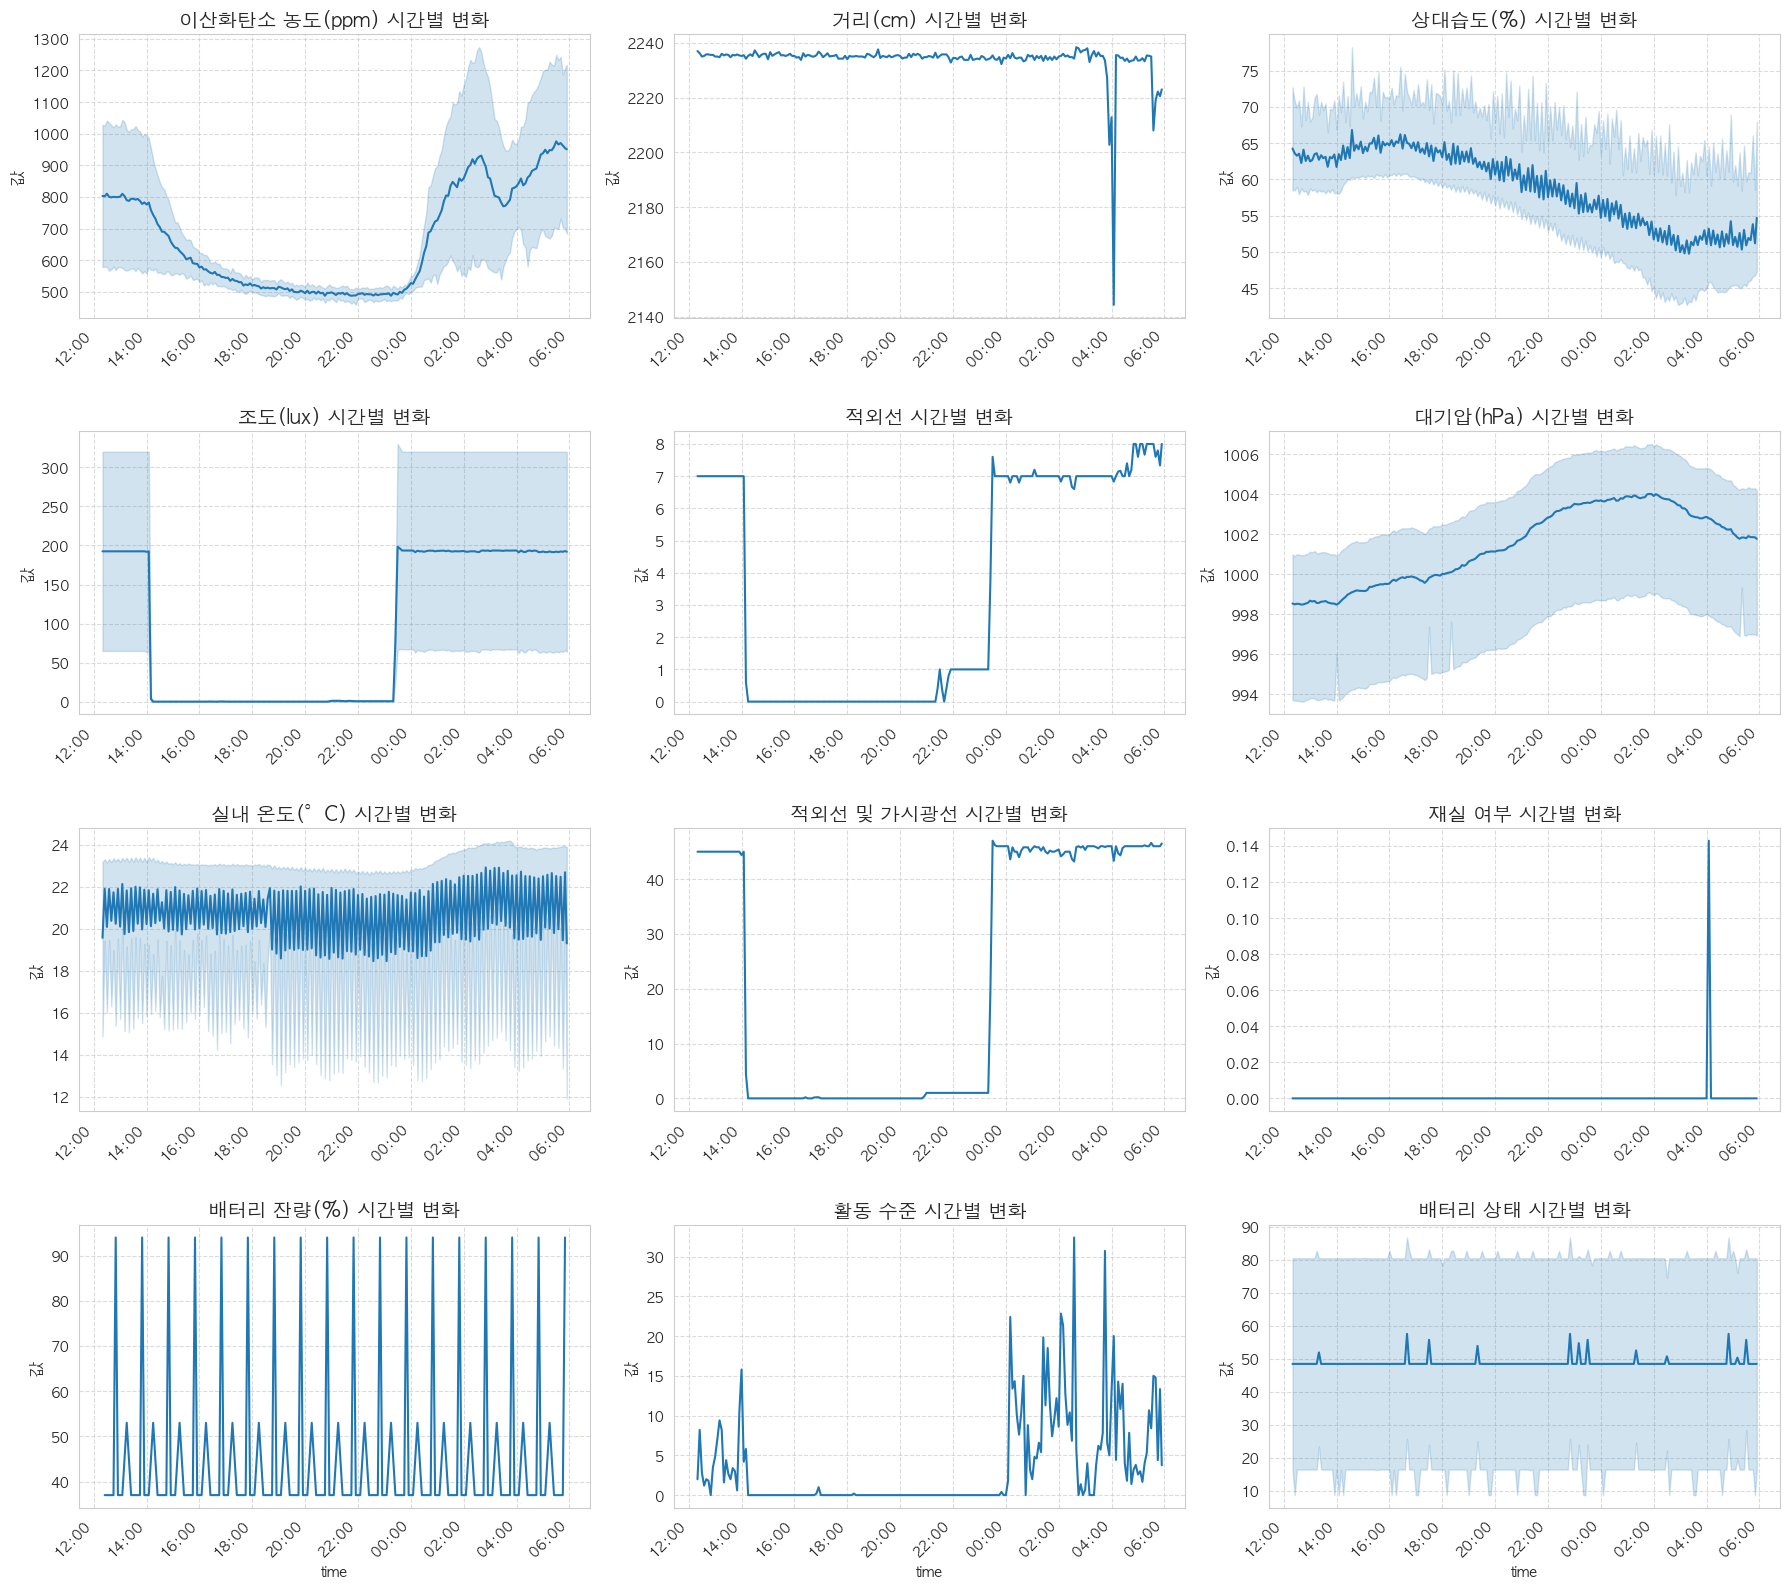

In [4]:
# 환경 모니터링 데이터 시각화 (한글 제목)
cols = 3
rows = math.ceil(len(sensor_types) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4), sharex=True)
axes = axes.flatten()

for i, t in enumerate(sensor_types):
    temp = df[df['type'] == t]
    if not temp.empty:
        # 데이터 시각화
        sns.lineplot(ax=axes[i], data=temp, x=temp.index, y='_value')
        
        # 한글 타이틀 적용
        korean_title = sensor_type_mapping.get(t, t)
        axes[i].set_title(f'{korean_title} 시간별 변화', fontsize=14)
        
        # y축 레이블 설정
        axes[i].set_ylabel('값', fontsize=12)
        
        # 시간 형식 설정 (시:분 형식으로 표시)
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        
        # 적절한 간격으로 눈금 설정 (2시간 간격)
        axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=2))
        
        # 모든 서브플롯에 x축 레이블 표시
        axes[i].tick_params(axis='x', labelbottom=True)
        
        # x축 레이블 회전
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
        
        # 그리드 추가
        axes[i].grid(True, linestyle='--', alpha=0.7)

# 빈 서브플롯 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.gcf().canvas.draw()
plt.subplots_adjust(hspace=0.4)  # 수직 간격 조정
plt.savefig('환경_모니터링_한글.png', dpi=300, bbox_inches='tight')
plt.show()


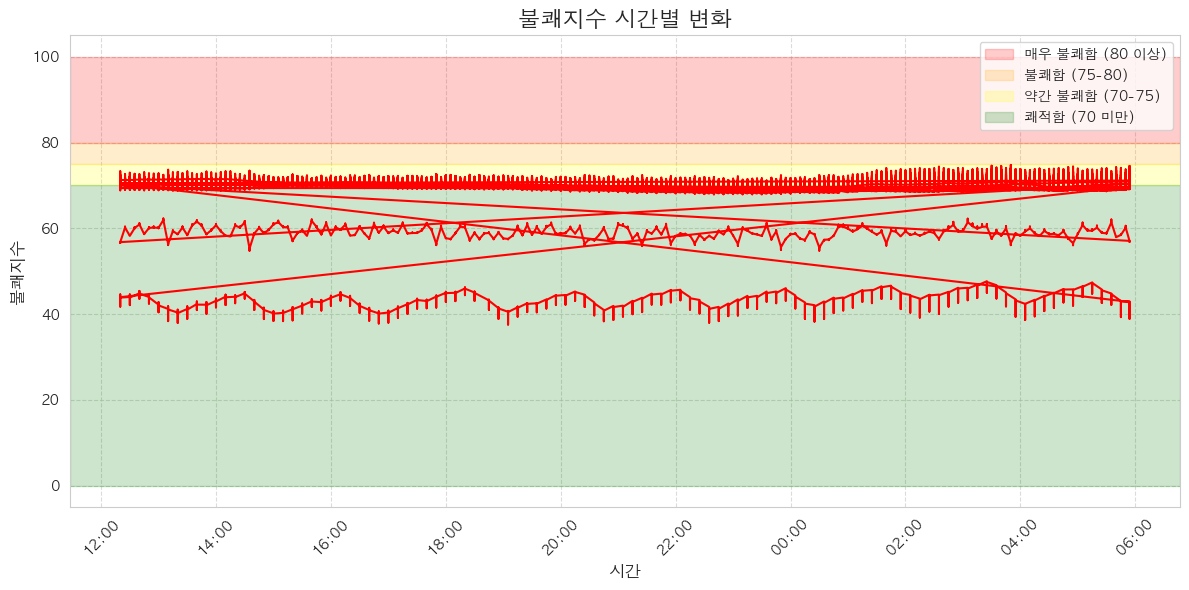

In [5]:
# 온도와 습도 데이터를 각각 시계열로 준비
temp_data = df[df['type'] == 'temperature'][['_value']]
humidity_data = df[df['type'] == 'humidity'][['_value']]

# 컬럼 이름 바꾸기 (merge 시 중복 방지)
temp_data.rename(columns={'_value': 'temperature'}, inplace=True)
humidity_data.rename(columns={'_value': 'humidity'}, inplace=True)

# 공통 시간대를 기준으로 병합 (inner join)
merged = pd.merge(temp_data, humidity_data, left_index=True, right_index=True, how='inner')

# 불쾌지수 계산
discomfort_values = calculate_discomfort_index(
    merged['temperature'].values,
    merged['humidity'].values
)

# 결과 DataFrame 구성
discomfort_df = merged.copy()
discomfort_df['discomfort_index'] = discomfort_values

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(discomfort_df.index, discomfort_df['discomfort_index'], 'r-')
plt.title('불쾌지수 시간별 변화', fontsize=16)
plt.xlabel('시간', fontsize=12)
plt.ylabel('불쾌지수', fontsize=12)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.xticks(rotation=45)

# 불쾌지수 범위 시각적 표시
plt.axhspan(80, 100, alpha=0.2, color='red', label='매우 불쾌함 (80 이상)')
plt.axhspan(75, 80, alpha=0.2, color='orange', label='불쾌함 (75-80)')
plt.axhspan(70, 75, alpha=0.2, color='yellow', label='약간 불쾌함 (70-75)')
plt.axhspan(0, 70, alpha=0.2, color='green', label='쾌적함 (70 미만)')

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('불쾌지수_분석.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# 시간 기준 정렬
df.sort_index(inplace=True)

# 각 변수별 결측치 확인
print(df.groupby('type')['_value'].apply(lambda x: x.isna().sum()))

# 결측치 보간 또는 제거 (보간 추천)
df['_value'] = df.groupby('type')['_value'].transform(lambda x: x.interpolate(method='time'))


type
activity                0
battery                 0
battery_level           0
co2                     0
distance                0
humidity                0
illumination            0
infrared                0
infrared_and_visible    0
occupancy               0
pressure                0
temperature             0
Name: _value, dtype: int64


# 

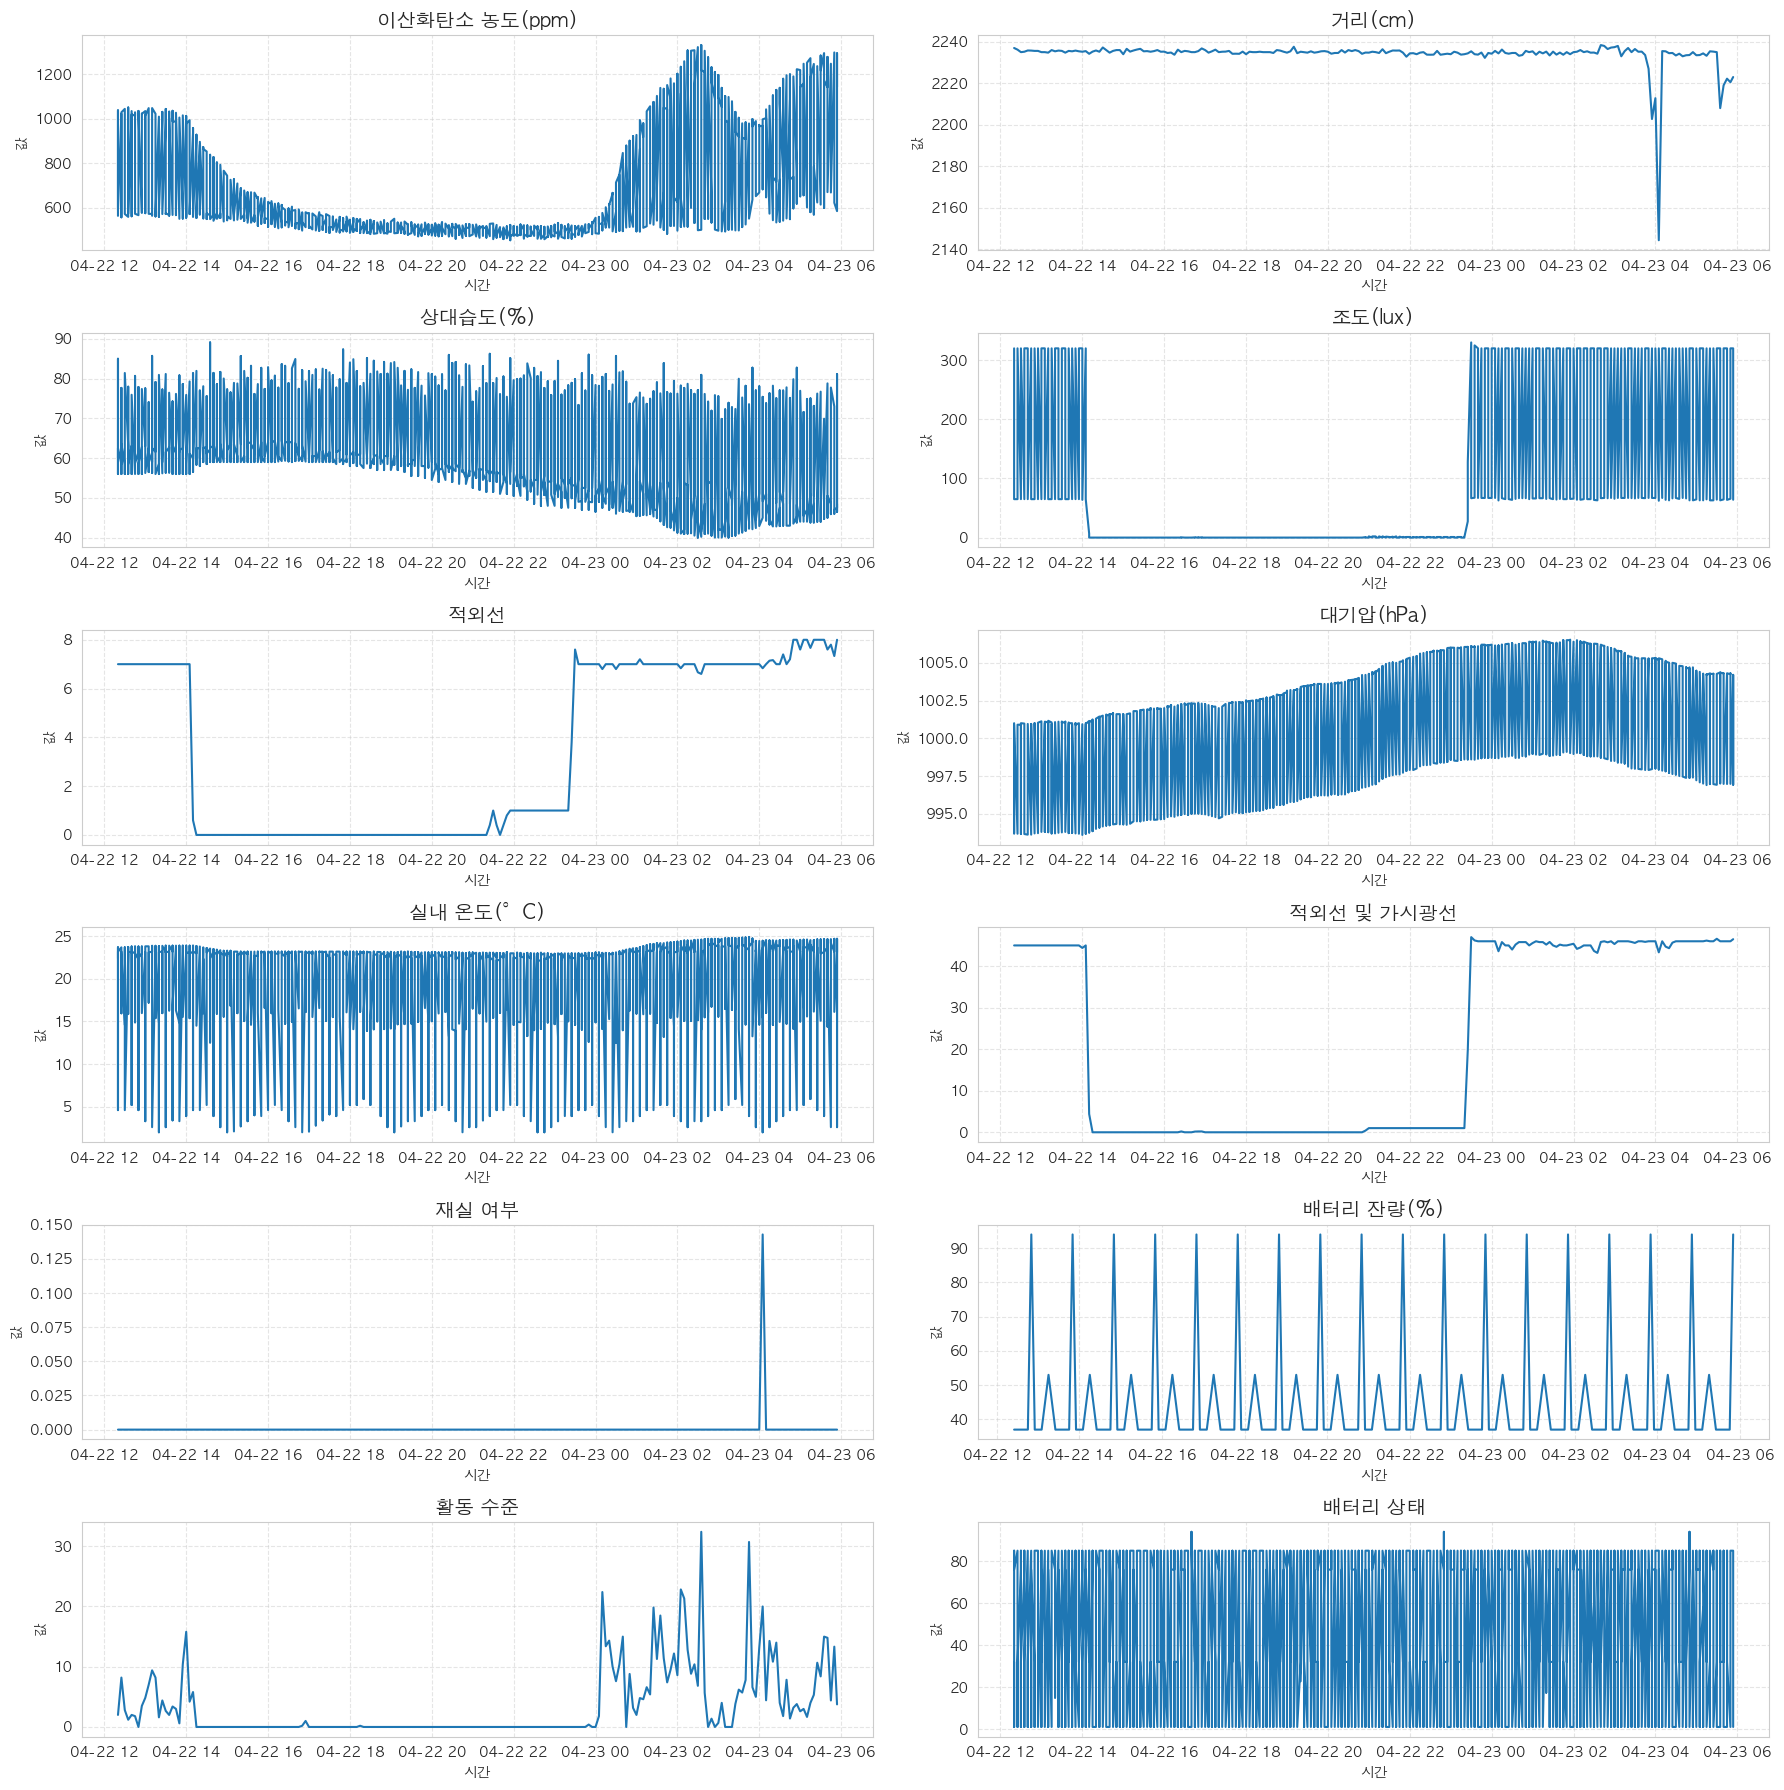

In [7]:
num_sensors = len(sensor_types)
cols = 2  # 한 행에 2개씩
rows = (num_sensors + cols - 1) // cols  # 필요한 행 개수 계산

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3), sharex=False)
axes = axes.flatten()

for i, sensor in enumerate(sensor_types):
    subset = df[df['type'] == sensor]
    axes[i].plot(subset.index, subset['_value'])
    # 한글 매핑 적용
    axes[i].set_title(sensor_type_mapping.get(sensor, sensor), fontsize=14)
    axes[i].set_xlabel('시간')
    axes[i].set_ylabel('값')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# 남는(빈) subplot은 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


